# Proyecto práctico

## Estudiante: Jorge Delgado González.

## Unidad 3 - Aprendizaje supervisado

El proyecto práctico consiste en abordar un problema de clasificación de documentos textuales. Tenemos a nuestra disposición un dataset de noticias de prensa en español publicada por el medio "CNN Chile".

Las noticias están divididas en 7 categorías temáticas: *'pais','deportes','tendencias','tecnologias','cultura','economia','mundo'*

El proyecto se divide en dos partes:

- Utilizar al menos 3 estrategías para entrenar modelos de clasificación capaces de clasificar las noticias según su categoría temática.

- Explorar cuáles son las características que permiten explicar las decisiones de su modelo.

## 0. Evaluación

El proyecto se realiza de forma individual. Se entrega a más tardar el **lunes 30 de noviembre** en su repositorio GitHub.

**Pauta de evaluación:**

Competencia 1: Aplicar un protocolo de aprendizaje supervisado para resolver un problema clasificación estandar, utilizando un entorno de programación en Python

- < 2 : El protocolo de aprendizaje supervisado utilizado es incompleto y/o presenta errores importantes
- 2 a 3.9 : El protocolo de aprendizaje supervisado utilizado es incompleto o presenta un error importante
- 4 a 5.5 : El protocolo de aprendizaje es completo, no tiene error, pero las estrategias utilizadas son relativamente simples y el rendimiento de los modelos es perfectible.
- 5.6 a 7.0 : El protocolo de aprendizaje es completo, no tiene error y al menos una de las estrategias utilizadas a necesitado un trabajado más avanzado y/o permite obtener un mejor rendimiento.

Competencia 2: Explicar el rendimiento de un modelo de clasificación aplicando un protocolo de evaluación Precision/Recall/F-Score

- < 2 : El trabajo no presenta explicaciones del rendimiento de los modelos de clasificación
- 2 a 3.9 : El trabajo presenta algunas explicaciones pero tienen errores.
- 4 a 5.5 : El trabajo presenta explicaciones correctas del rendimiento de los modelos
- 5.6 a 7 : El trabajo presenta explicaciones correctas del rendimiento de los modelos y además presenta un método para explicar las decisiones/errores


## 1. Dataset

In [1]:
import sys
#!{sys.executable} -m pip install pandasql

In [2]:
import pandas as pd
import time
import spacy
import seaborn as sns
from sklearn.metrics import f1_score
from simpletransformers.classification import ClassificationModel, ClassificationArgs

/opt/conda/lib/python3.8/site-packages/torch/cuda/__init__.py:52: UserWarning: CUDA initialization: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx (Triggered internally at  /pytorch/c10/cuda/CUDAFunctions.cpp:100.)
  return torch._C._cuda_getDeviceCount() > 0


In [26]:
#!{sys.executable} -m spacy download es

In [3]:
nlp = spacy.load("es")


df = pd.read_csv('cnnchile_7000.csv')
df[:4]

,country,media_outlet,url,title,text,date,category
0,chile,cnnchile,https://www.cnnchile.com/pais/pdta-del-colegio...,Pdta. del Colegio de Matronas explicó los ries...,La Federación de Estudiantes de la Universidad...,2018-03-29 00:00:00.000000,pais
1,chile,cnnchile,https://www.cnnchile.com/pais/defensoria-ninez...,Defensoría de la Niñez pide al Estado velar po...,La Defensoría de la Niñez emitió este domingo ...,2020-08-02 00:00:00.000000,pais
2,chile,cnnchile,https://www.cnnchile.com/pais/cuanto-les-pagar...,¿Cuánto les pagarán a los vocales de mesa?,El monto del bono es de dos tercios de Unidad ...,2016-10-20 00:00:00.000000,pais
3,chile,cnnchile,https://www.cnnchile.com/pais/sobrino-de-aleja...,Sobrino de Alejandro Navarro intenta “funar” e...,Una nueva polémica tiene esta carrera presiden...,2017-11-13 00:00:00.000000,pais


In [4]:
from pandasql import sqldf

q="""SELECT category, count(*) FROM df GROUP BY category ORDER BY count(*) DESC;"""
result=sqldf(q)
result

,category,count(*)
0,tendencias,1000
1,tecnologias,1000
2,pais,1000
3,mundo,1000
4,economia,1000
5,deportes,1000
6,cultura,1000


### 1.1 Preprocessing Data

A partir de la tabla presentada anteriormente, es necesario descartar las columnas de data/metadata asociada como el país, url, fecha y medio.

In [5]:
data=df.drop(columns=['country', 'media_outlet','url','date'])
data[:5]

,title,text,category
0,Pdta. del Colegio de Matronas explicó los ries...,La Federación de Estudiantes de la Universidad...,pais
1,Defensoría de la Niñez pide al Estado velar po...,La Defensoría de la Niñez emitió este domingo ...,pais
2,¿Cuánto les pagarán a los vocales de mesa?,El monto del bono es de dos tercios de Unidad ...,pais
3,Sobrino de Alejandro Navarro intenta “funar” e...,Una nueva polémica tiene esta carrera presiden...,pais
4,Análisis sobre el aumento de impuestos para al...,Especialistas recomiendan no consumir más de 2...,pais


En cambio, para aprovechar los campos de título y texto como elementos independientes de igual etiqueta, serán concatenados uno despues del otro, generando sólo 1 columna de data de entrenamiento.

In [6]:
result=data['title'].append(data['text'],ignore_index=True)

In [7]:
result=result.to_frame(name="text")

In [8]:
result["category"]=data["category"].append(data["category"],ignore_index=True)

Se revisan las dimensiones y validez/existencia de datos

In [9]:
result.head()

,text,category
0,Pdta. del Colegio de Matronas explicó los ries...,pais
1,Defensoría de la Niñez pide al Estado velar po...,pais
2,¿Cuánto les pagarán a los vocales de mesa?,pais
3,Sobrino de Alejandro Navarro intenta “funar” e...,pais
4,Análisis sobre el aumento de impuestos para al...,pais


In [10]:
result.shape

(14000, 2)

In [11]:
result.isnull().sum()

text        1
category    0
dtype: int64

Existe 1 campo sin información, que es necesario eliminar (la fila).

In [12]:
result.dropna(inplace=True)

In [13]:
result.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13999 entries, 0 to 13999
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   text      13999 non-null  object
 1   category  13999 non-null  object
dtypes: object(2)
memory usage: 328.1+ KB


Analizamos si existe un balance en el conjunto de datos

/opt/conda/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


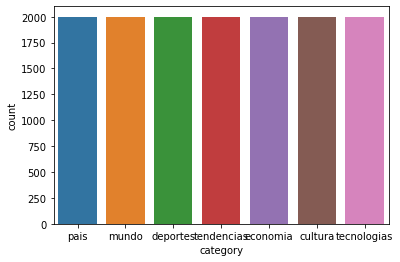

In [14]:
sns.countplot(result['category']);

### 1.2 Procesamiento de features

In [15]:
def feature_extraction(text):
    
    mytokens = nlp(text)

    #Guardamos las palabras como características si corresponden a ciertas categorias gramaticales
    mytokens = [ word for word in mytokens if word.pos_ in ["NOUN", "ADJ", "VERB"] ]
    
    #Transformamos las palabras en minusculas
    mytokens = [ word.lemma_.lower().strip() for word in mytokens ]

    # return preprocessed list of tokens
    return mytokens

In [16]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vector = TfidfVectorizer(tokenizer = feature_extraction, min_df=0., max_df=1.0)

Separación de los datos entre campos de información y labels objetivo

In [17]:
from sklearn.model_selection import train_test_split

X = result['text']
ylabels = result['category']

In [18]:
from sklearn.preprocessing import LabelEncoder
lb = LabelEncoder()
ylabels_encoded = lb.fit_transform(ylabels)

Separación de los set de entrenamiento y set de validación

In [19]:
X_train, X_test, y_train, y_test = train_test_split(X, ylabels_encoded, test_size=0.3)

In [20]:
X_train

10725    Una insólita situación se vivió en un partido ...
5962     Hay que ver: La criticada secuela de “El Respl...
2870     “El Piñon” ganó en el “Premio Tanteo” en el Hi...
9439     En una Hípica en CNN Chile te invitamos a cono...
2328     Argentina derrotó a Bélgica y accedió a semifi...
                               ...                        
8300     Serán 115 los cardenales que tendrán derecho a...
2648     Carlo de Gavardo vaticinó que Chile ganaba la ...
9048     Este martes Colo Colo hará su debut en la Copa...
3645     Laura Gutman explicó las bases de su metodolog...
2814     “La Rojita” ya está en Chile tras clasificar a...
Name: text, Length: 9799, dtype: object

---

### 2.0 - K vecinos más cercanos

In [119]:
from sklearn.neighbors import neighbors
from sklearn.pipeline import Pipeline
#con 7: 
n_neighbors = 1 #Número de clases a priori que buscamos

knn = neighbors.KNeighborsClassifier(n_neighbors)

model_knn = Pipeline([('vectorizing', tfidf_vector),
                 ('learning', knn)])

In [120]:
start = time.time()

model_knn.fit(X_train, y_train)

end = time.time()
print("tiempo para entrenar:" + str(end - start))

tiempo para entrenar:110.80668330192566


In [121]:
from sklearn import metrics

start = time.time()

predicted_knn = model_knn.predict(X_test)

end = time.time()
print("tiempo para predecir:" + str(end - start))

tiempo para predecir:47.948946475982666


In [122]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

confusion_matrix = confusion_matrix(y_test, predicted_knn)

print(confusion_matrix)

print(classification_report(y_test, predicted_knn))

[[ 64 517   1   6   0   0   7]
 [  3 531   8  15   4  17  10]
 [  1 486 110  28   6   4   3]
 [  5 489   5 101   3   3   6]
 [  0 518   7  26  49   4   3]
 [  3 449   1  15   3  76  17]
 [  7 515   4   8   1  17  44]]
              precision    recall  f1-score   support

           0       0.77      0.11      0.19       595
           1       0.15      0.90      0.26       588
           2       0.81      0.17      0.28       638
           3       0.51      0.17      0.25       612
           4       0.74      0.08      0.15       607
           5       0.63      0.13      0.22       564
           6       0.49      0.07      0.13       596

    accuracy                           0.23      4200
   macro avg       0.59      0.23      0.21      4200
weighted avg       0.59      0.23      0.21      4200



Con un mal rendimiento este modelo será dejado de lado por ahora pero analizado en la etapa final.
Dicho esto, procederemos con 4 otros modelos de diversa dificultad para testear su clasificación.

### 2.1 - Árbol de decisión

In [36]:
from sklearn import tree

my_tree = tree.DecisionTreeClassifier()

model_tree = Pipeline([('vectorizing', tfidf_vector),
                 ('learning', my_tree)])

In [37]:
start = time.time()

model_tree.fit(X_train, y_train)

end = time.time()
print("tiempo para entrenar:" + str(end - start))

tiempo para entrenar:115.98631978034973


In [52]:
start = time.time()

predicted_dt = model_tree.predict(X_test)

end = time.time()
print("tiempo para predecir:" + str(end - start))

tiempo para predecir:49.054983139038086


In [53]:
confusion_matrix = metrics.confusion_matrix(y_test, predicted_dt)

print(confusion_matrix)

print(classification_report(y_test, predicted_dt))

[[361  29   7  46  39  30  83]
 [ 28 374  20  26  27  32  81]
 [ 11  24 390  44  76  39  54]
 [ 38  46  57 269  83  37  82]
 [ 30  28  77  96 262  36  78]
 [ 28  48  50  35  30 256 117]
 [ 68  63  30  36  66  98 235]]
              precision    recall  f1-score   support

           0       0.64      0.61      0.62       595
           1       0.61      0.64      0.62       588
           2       0.62      0.61      0.61       638
           3       0.49      0.44      0.46       612
           4       0.45      0.43      0.44       607
           5       0.48      0.45      0.47       564
           6       0.32      0.39      0.35       596

    accuracy                           0.51      4200
   macro avg       0.52      0.51      0.51      4200
weighted avg       0.52      0.51      0.51      4200



In [54]:
txt_representation = tree.export_text(my_tree, feature_names=tfidf_vector.get_feature_names(), max_depth=10)
print(txt_representation)

|--- artista <= 0.01
|   |--- económico <= 0.06
|   |   |--- gol <= 0.03
|   |   |   |--- aplicación <= 0.02
|   |   |   |   |--- jugador <= 0.04
|   |   |   |   |   |--- película <= 0.01
|   |   |   |   |   |   |--- presidente <= 0.02
|   |   |   |   |   |   |   |--- tecnología <= 0.03
|   |   |   |   |   |   |   |   |--- canción <= 0.01
|   |   |   |   |   |   |   |   |   |--- video <= 0.08
|   |   |   |   |   |   |   |   |   |   |--- alzar <= 0.04
|   |   |   |   |   |   |   |   |   |   |   |--- truncated branch of depth 960
|   |   |   |   |   |   |   |   |   |   |--- alzar >  0.04
|   |   |   |   |   |   |   |   |   |   |   |--- truncated branch of depth 11
|   |   |   |   |   |   |   |   |   |--- video >  0.08
|   |   |   |   |   |   |   |   |   |   |--- adjuntar <= 0.05
|   |   |   |   |   |   |   |   |   |   |   |--- truncated branch of depth 37
|   |   |   |   |   |   |   |   |   |   |--- adjuntar >  0.05
|   |   |   |   |   |   |   |   |   |   |   |--- truncated branch of dep

### 2.2 - Gradient Boosting Classifier

In [90]:
from sklearn.ensemble import GradientBoostingClassifier
clf = GradientBoostingClassifier(n_estimators=100, learning_rate=0.4,
                                 max_depth=7, random_state=0)
model_GBC = Pipeline([('vectorizing', tfidf_vector),
                 ('learning', clf)])

In [91]:
start = time.time()

model_GBC.fit(X_train, y_train)

end = time.time()
print("tiempo para entrenar:" + str(end - start))

tiempo para entrenar:218.84854459762573


In [92]:
start = time.time()

predicted_GBC = model_GBC.predict(X_test)

end = time.time()
print("tiempo para predecir:" + str(end - start))

tiempo para predecir:47.44646668434143


In [94]:
confusion_matrix = metrics.confusion_matrix(y_test, predicted_GBC)

print(confusion_matrix)

print(classification_report(y_test, predicted_GBC))

[[416   9   6  29  43  12  80]
 [ 11 422  15  24  23  17  76]
 [  5  13 449  36  58  26  51]
 [ 22  22  38 346  75  23  86]
 [ 16  17  57  88 328  24  77]
 [ 24  29  28  19  28 317 119]
 [ 52  38  13  48  29  72 344]]
              precision    recall  f1-score   support

           0       0.76      0.70      0.73       595
           1       0.77      0.72      0.74       588
           2       0.74      0.70      0.72       638
           3       0.59      0.57      0.58       612
           4       0.56      0.54      0.55       607
           5       0.65      0.56      0.60       564
           6       0.41      0.58      0.48       596

    accuracy                           0.62      4200
   macro avg       0.64      0.62      0.63      4200
weighted avg       0.64      0.62      0.63      4200



### 2.3 - Naïve Bayes

In [31]:
from sklearn.naive_bayes import MultinomialNB

nb = MultinomialNB()

model_nb = Pipeline([('vectorizing', tfidf_vector),
                 ('learning', nb)])

In [32]:
start = time.time()

model_nb.fit(X_train, y_train)

end = time.time()
print("tiempo para entrenar:" + str(end - start))

tiempo para entrenar:112.64363527297974


In [46]:
start = time.time()

predicted_nb = model_nb.predict(X_test)

end = time.time()
print("tiempo para predecir:" + str(end - start))

tiempo para predecir:47.97105360031128


In [50]:
confusion_matrix = metrics.confusion_matrix(y_test, predicted_nb)

print(confusion_matrix)

print(classification_report(y_test, predicted_nb))

[[547   3   4  11  13   5  12]
 [ 29 481  18  11  14  11  24]
 [  7   1 544  18  34  31   3]
 [ 32  13  48 411  64  26  18]
 [ 21   9  63  63 417  23  11]
 [ 32  14  25  19  14 420  40]
 [112  38  16  27  21 116 266]]
              precision    recall  f1-score   support

           0       0.70      0.92      0.80       595
           1       0.86      0.82      0.84       588
           2       0.76      0.85      0.80       638
           3       0.73      0.67      0.70       612
           4       0.72      0.69      0.70       607
           5       0.66      0.74      0.70       564
           6       0.71      0.45      0.55       596

    accuracy                           0.73      4200
   macro avg       0.74      0.73      0.73      4200
weighted avg       0.74      0.73      0.73      4200



### 2.4 Ada Boost

In [144]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier

ada = AdaBoostClassifier(DecisionTreeClassifier(max_depth=2),n_estimators=50,learning_rate=1)

model_ada = Pipeline([('vectorizing', tfidf_vector),
                 ('learning', ada)])

In [145]:
model_ada.fit(X_train, y_train)

Pipeline(steps=[('vectorizing',
                 TfidfVectorizer(min_df=0.0,
                                 tokenizer=<function feature_extraction at 0x7f56413d8670>)),
                ('learning',
                 AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=2),
                                    learning_rate=1))])

In [146]:
predicted_ab = model_ada.predict(X_test)

In [147]:
from sklearn import metrics
from sklearn.metrics import classification_report
confusion_matrix = metrics.confusion_matrix(y_test, predicted_ab)

print(confusion_matrix)

print(classification_report(y_test, predicted_ab))

[[375   7   5  22  28  16 142]
 [ 12 310   3  12  19  10 222]
 [  4  22 369  16  39  11 177]
 [ 24  22  31 185  70  11 269]
 [ 11  15  54  65 207  12 243]
 [ 22  26  22  14  10 233 237]
 [ 56  30  12  21  42  51 384]]
              precision    recall  f1-score   support

           0       0.74      0.63      0.68       595
           1       0.72      0.53      0.61       588
           2       0.74      0.58      0.65       638
           3       0.55      0.30      0.39       612
           4       0.50      0.34      0.41       607
           5       0.68      0.41      0.51       564
           6       0.23      0.64      0.34       596

    accuracy                           0.49      4200
   macro avg       0.59      0.49      0.51      4200
weighted avg       0.59      0.49      0.51      4200



---

## Resultados

Las soluciones quedan almacenadas en:

In [148]:
print("k-nearest neighbors: ",predicted_knn)
print("Árbol de decisión: ",predicted_dt)
print("Gradient Tree boosting: ",predicted_GBC)
print("Naive Bayes: ",predicted_nb)
print("Ada Boost: ",predicted_ab)

k-nearest neighbors:  [1 1 1 ... 1 1 1]
Árbol de decisión:  [1 4 5 ... 3 6 1]
Gradient Tree boosting:  [6 6 2 ... 5 5 1]
Naive Bayes:  [3 4 2 ... 2 5 1]
Ada Boost:  [6 6 2 ... 6 6 1]


Analizando las métricas de estos resultados:

* Accuracy 

In [149]:
from sklearn.metrics import accuracy_score
print("k-nearest neighbors: ",accuracy_score(y_test, predicted_knn))
print("Árbol de decisión: ",accuracy_score(y_test, predicted_dt))
print("Gradient Tree boosting: ",accuracy_score(y_test, predicted_GBC))
print("Naive Bayes: ",accuracy_score(y_test, predicted_nb))
print("Ada Boost: ",accuracy_score(y_test, predicted_ab))

k-nearest neighbors:  0.23214285714285715
Árbol de decisión:  0.5111904761904762
Gradient Tree boosting:  0.6242857142857143
Naive Bayes:  0.7347619047619047
Ada Boost:  0.4911904761904762


* Recall

In [150]:
from sklearn.metrics import recall_score

print("k-nearest neighbors: ",recall_score(y_test, predicted_knn, average='macro'))
print("Árbol de decisión: ",recall_score(y_test, predicted_dt, average='macro'))
print("Gradient Tree boosting: ",recall_score(y_test, predicted_GBC, average='macro'))
print("Naive Bayes: ",recall_score(y_test, predicted_nb, average='macro'))
print("Ada Boost: ",recall_score(y_test, predicted_ab, average='macro'))

k-nearest neighbors:  0.2339104107698223
Árbol de decisión:  0.5104902634555486
Gradient Tree boosting:  0.6236526221669509
Naive Bayes:  0.734223270729743
Ada Boost:  0.49093682272039996


* F1

In [151]:
from sklearn.metrics import f1_score
print("k-nearest neighbors: ",f1_score(y_test, predicted_knn, average='macro'))
print("Árbol de decisión: ",f1_score(y_test, predicted_dt, average='macro'))
print("Gradient Tree boosting: ",f1_score(y_test, predicted_GBC, average='macro'))
print("Naive Bayes: ",f1_score(y_test, predicted_nb, average='macro'))
print("Ada Boost: ",f1_score(y_test, predicted_ab, average='macro'))

k-nearest neighbors:  0.2110521744561987
Árbol de decisión:  0.5123986787909877
Gradient Tree boosting:  0.6288014475383091
Naive Bayes:  0.7276082497197127
Ada Boost:  0.5126303969684233


Por un lado tenemos el método de KNN que llama la atención por su mal rendimiento en todas las métricas, registrando tasas de éxito del 20%. Aún cuando este método es utilizado dentro de contextos de clasificación de textos en otras circunstancias, el escenario presentado de noticias puede conllevar a una nula posibilidad de separación linear entre sus muestras, dando pésimos resultados con los distintos k probados (Desde 1 hasta 7).

Por otro, tenemos 3 algoritmos con un resultado medianamente débil o mejorable (50~69%), su punto en común es que nacen de la idea de básica de **árboles de decisión**, implementando una u otra forma de optimización **secuencial** en sus decisiones. Mientras que **Adaboost** realiza una actualización de pesos en cada modelo con el set resultante, **GBC** realiza una valoración tanto del siguiente modelo como de los anteriores, minizando el error de predicción.

Y finalizando con el mejor resultado de entrenamiento, el modelo de **Naive Bayes** alcanza los valores de precision y recall más altos para las distintas clases, demostrando no sólo una alta tasa de positivos sobre el total, sino una buena robustez en un análisis de 6 clases, con valores sobre el 70%~. A continuación se muestran las palabras claves del modelo: 

In [153]:
def get_salient_words(nb_clf, vect, class_ind):
    words = vect.get_feature_names()
    zipped = list(zip(words, nb_clf.feature_log_prob_[class_ind]))
    sorted_zip = sorted(zipped, key=lambda t: t[1], reverse=True)

    return sorted_zip

neg_salient_top = get_salient_words(nb, tfidf_vector, 0)[:10]
pos_salient_top = get_salient_words(nb, tfidf_vector, 1)[:10]

print(neg_salient_top)
print(pos_salient_top)

[('ser', -6.3882927871602675), ('año', -6.506275407959388), ('nuevo', -6.6185166579143395), ('película', -6.641571462718275), ('canción', -6.682336274434772), ('”', -6.7126520771902225), ('artista', -6.844945050425365), ('tener', -6.90053979048079), ('músico', -6.919641442164756), ('estrenar', -7.016563201437288)]
[('chileno', -6.6018193384713975), ('partir', -6.698047180439879), ('jugador', -6.74590781943437), ('ganar', -6.773427333916589), ('gol', -6.7770323822283505), ('colo', -6.807622788293902), ('rojo', -6.8081216541073735), ('fútbol', -6.833204185875901), ('ser', -6.834222701073478), ('jugar', -6.904930253187365)]


Para concluir, aún cuando los modelos utilizados son de uso común en ámbitos de clasificación (binaria o multilabel) es necesario considerar aspectos propios del dataset para determinar cual resulta más práctico de implementar. En este caso donde el dataset original trató de igual manera los título de noticias como su propio contenido, es posible conseguir un mejor resultado en un modelo de bayes condicional, que utilice principios de indepencia para estimar de mejor forma la **temática** de cada una.

### Algunas referencias
* https://arxiv.org/pdf/1705.05311.pdf
* https://medium.com/axel-springer-tech/how-to-classify-news-articles-in-the-real-world-144cc9f99540
* https://www.displayr.com/gradient-boosting-the-coolest-kid-on-the-machine-learning-block/#:~:text=Gradient%20boosting%20is%20a%20type,minimizes%20the%20overall%20prediction%20error.&text=reduce%20the%20error.-,If%20a%20small%20change%20in%20the%20prediction%20for%20a%20case,of%20the%20case%20is%20zero.